This notebook is designed to test which standardization method is best suited for the purpose of our project. We have tested various methods using the `standardize_tool` function, they are listed in the function description.    

The methods were evaluated by the `standardization_comparison_tool` function. The shape of the distribution was assessed, along with the distance to a normal distribution measured with the Cramer von Mises distance. As a result, the method that standardizes and scales float columns to the interval [-1, 1] using a sigmoid function was chosen as the main standardization method in this project, as it outperformed all other methods in the evaluation.

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from cities.utils.data_grabber import DataGrabber


In [12]:
def standardize_margins(data: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes and scales float columns in a DataFrame to [-1,1], copying other columns. Returns a new DataFrame.
    """
    standard_scaler = StandardScaler()

    new_data = pd.DataFrame()
    for column in data.columns:
        if data.dtypes[column] != "float64":
            new_data[column] = data[column].copy()
        else:
            new = data[column].copy().values.reshape(-1, 1)
            new = standard_scaler.fit_transform(new)

            positive_mask = new >= 0
            negative_mask = new < 0

            min_positive = np.min(new[positive_mask])
            max_positive = np.max(new[positive_mask])
            scaled_positive = (new[positive_mask] - min_positive) / (
                max_positive - min_positive
            )

            min_negative = np.min(new[negative_mask])
            max_negative = np.max(new[negative_mask])
            scaled_negative = (new[negative_mask] - min_negative) / (
                max_negative - min_negative
            ) - 1

            scaled_values = np.empty_like(new, dtype=float)
            scaled_values[positive_mask] = scaled_positive
            scaled_values[negative_mask] = scaled_negative

            new_data[column] = scaled_values.reshape(-1)

    return new_data

In [13]:
def standardize_sigm(data: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes and scales float columns in a DataFrame to [-1,1], copying other columns. Returns a new DataFrame.
    """
    standard_scaler = StandardScaler()  # Standardize to mean 0, std 1

    def sigmoid(x, scale=1 / 3):
        range_0_1 = 1 / (1 + np.exp(-x * scale))
        range_minus1_1 = 2 * range_0_1 - 1
        return range_minus1_1

    # Copy all columns first
    new_data = data.copy()

    # Select float columns
    float_cols = data.select_dtypes(include=["float64"])

    # Standardize float columns to mean 0, std 1
    standardized_floats = standard_scaler.fit_transform(float_cols)

    # Apply sigmoid transformation, [-3std, 3std] to [-1, 1]
    new_data[float_cols.columns] = sigmoid(standardized_floats, scale=1 / 3)

    return new_data


def log10_scaling(data: pd.DataFrame, offset=1e-10) -> pd.DataFrame:
 
    float_columns = data.select_dtypes(include=['float64'])
    log10_data = float_columns.apply(lambda x: np.log10(x + offset)) 
    result = data.copy()
    result[float_columns.columns] = log10_data

    return result



def arcsinh_scaling(data: pd.DataFrame,  offset=1e-10) -> pd.DataFrame:

    float_columns = data.select_dtypes(include=['float64'])
    asinh_data = float_columns.apply(lambda x: np.arcsinh(x + offset)) 
    result = data.copy()
    result[float_columns.columns] = asinh_data

    return result

In [14]:
def standardize_tool(data: pd.DataFrame, method: str = 'standard_sigm') -> pd.DataFrame:
    """
    - data (pd.DataFrame): Input DataFrame.
    - method (str): The transformation method to apply. Options include:
        - 'standard_sigm': Standardizes and scales float columns to the interval [-1, 1] using a sigmoid function.
        - 'standard_margins': Standardizes the data using margin standardization.
        - 'log10': Applies log base 10 scaling.
        - 'arcsinh': Applies inverse hyperbolic sine scaling.
        - 'log10_sigm': Applies log base 10 scaling followed by sigmoid standardization.

    Returns:
    - pd.DataFrame: DataFrame with the same shape as the input, but with values transformed.
    """

    if method == 'standard_margins':

        new_data = standardize_margins(data) 

    elif method == 'standard_sigm':

        new_data = standardize_sigm(data)
        
    elif method == 'log10':

        new_data = log10_scaling(data) 

    elif method == 'arcsinh':
    
        new_data = arcsinh_scaling(data)

    elif method == 'log10_sigm':
        
        data10 = log10_scaling(data) 
        new_data = standardize_sigm(data10) 

    else:
        raise ValueError("Invalid method. Supported methods are 'standard_sigm', 'standard_margins', log10_sigm, 'log10', and 'arcsinh'.")

    return new_data




In [15]:
def cramer_mises_dist(dist1, dist2):
    return np.sum((dist1 - dist2) ** 2)


def standarization_comparison_tool(dataset: str, column: str):

    """
    Comparison of the effects of different standardization methods on a specified column in a dataset.
    
    Parameters:
    - dataset (str): The name of the dataset to be used.
    - column (str): The column in the dataset to be visualized and compared.

    Note: The standardization methods and their parameters are hard-coded in the function.

    Example usage:
    standarization_comparison_tool('your_dataset_name', 'your_column_name')
    """



    data = DataGrabber()
    data.get_features_wide([dataset])
    data = data.wide[dataset]

    data_standardized = standardize_tool(data, 'log10_sigm')
    data_log10 = standardize_tool(data, 'log10')
    data_sigmoid = standardize_tool(data, 'arcsinh')
    data_log10_sigm = standardize_tool(data, 'standard_margins')


    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    axes[0, 0].hist(data_log10_sigm[column], bins=20, color='green')
    axes[0, 0].set_title(f'Histogram for {column} column, log10_sigm')
    
    axes[0, 1].hist(data_standardized[column], bins=20, color='steelblue')
    axes[0, 1].set_title(f'Histogram for {column} column, standard_sigm')
    
    axes[1, 0].hist(data_log10[column], bins=20, color='skyblue')
    axes[1, 0].set_title(f'Histogram for {column} column, log10')
    
    axes[1, 1].hist(data_sigmoid[column], bins=20, color='purple')
    axes[1, 1].set_title(f'Histogram for {column} column, arcsinh')
    
    plt.tight_layout()
    plt.show()

    length = len(data_standardized[column])
    mean = 0
    std_dev = 0.2  

    x = np.linspace(0, 10, length)
    normal_distribution = np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
    normal_distribution /= np.sum(normal_distribution)


  
    distance_standardized = cramer_mises_dist(normal_distribution, data_standardized[column])
    distance_log10 = cramer_mises_dist(normal_distribution, data_log10[column])
    distance_sigmoid = cramer_mises_dist(normal_distribution, data_sigmoid[column])
    data_log10_sigm = cramer_mises_dist(normal_distribution, data_log10_sigm[column])
    
    
    data = {
    "Method": ["sigm standard", "log10 sigmoid", "log10", "arcsinh"],
    f"Distance (for {column} column)": [distance_standardized, data_log10_sigm, distance_log10, distance_sigmoid]
    }

    distances_df = pd.DataFrame(data)

    distances_df = distances_df.sort_values(by=f"Distance (for {column} column)")

    distances_df = pd.DataFrame(data)

    print('Distance measurements to normal distribution calculated with Cramer von Mises distance:')
    print(distances_df)


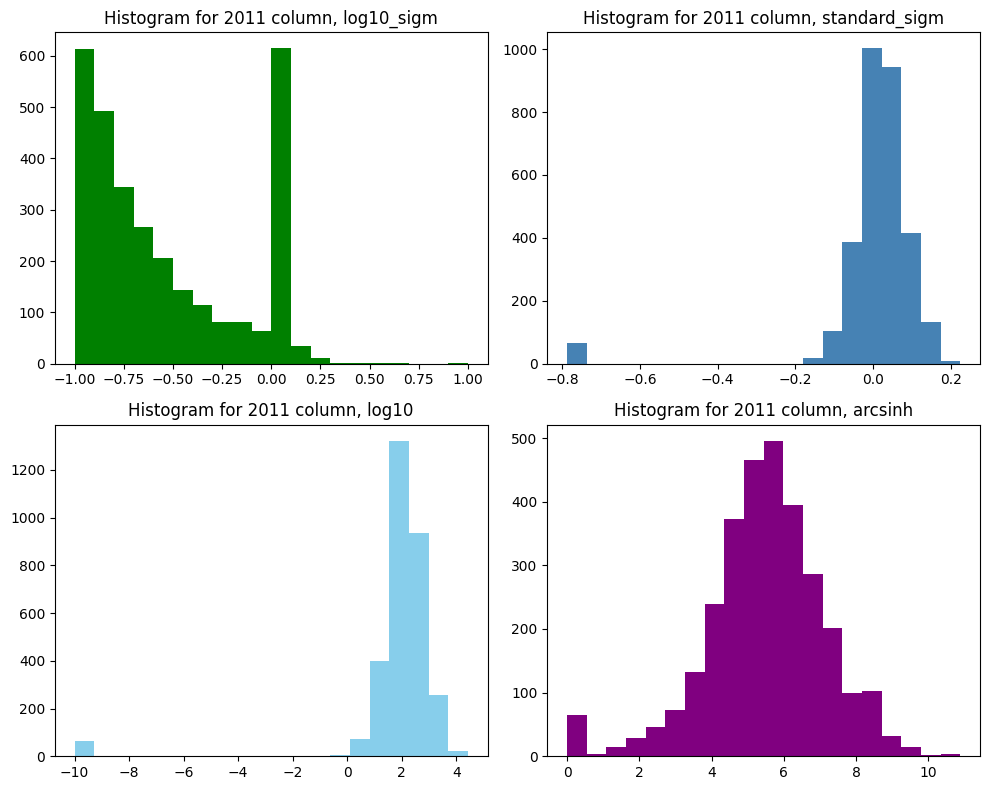

Distance measurements to normal distribution calculated with Cramer von Mises distance:
          Method  Distance (for 2011 column)
0  sigm standard                   51.669356
1  log10 sigmoid                 1345.240959
2          log10                21404.355611
3        arcsinh               100976.781811


In [16]:
standarization_comparison_tool('industry_utilities_total', '2011')